In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from macro_agent import MacroAgent, ReplayMemory, QNetwork, Transition
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional
#from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as datetime
from datetime import datetime
import matplotlib.dates as mdates
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
CAPACITY = 500
INIT_EPSILON = 0.9
GAMMA_DISCOUNT = 0.8
EPOCH_COUNT = 500
MINI_BATCH_SIZE = 10
WINDOW_SIZE = 20
ALPHA = 10000
ACTIONS={"SELL":torch.tensor([1,0,0], dtype=torch.float32),
 "HOLD":torch.tensor([0,1,0], dtype=torch.float32),
  "BUY":torch.tensor([0,0,1], dtype=torch.float32)}

In [3]:
class Environment:
    
    def __init__(self, all_data):
        self._all_data = all_data
        self._pointer = WINDOW_SIZE
        self.done = False
        
        pass

    def taken_action(self):
        self._pointer += 1
        if self._pointer >= len(self._all_data) - 1:
            self.done = True
        pass
    
    def get_price(self):
        return self._all_data.iloc[self._pointer]['Close']

    def get_change_zscore(self, column):
        start_idx = np.max([0, self._pointer - WINDOW_SIZE])
        frame = self._all_data.iloc[start_idx:self._pointer + 1]
        market_now = self._all_data.iloc[self._pointer]
        PC = market_now[column] / np.mean(frame[column]) - 1

        PCs = np.empty_like(frame[column])
        for i in range(start_idx, self._pointer + 1):
            start_frame = np.max([0, i - WINDOW_SIZE])
            end_frame = i
            PCs[i - start_idx] = self._all_data.iloc[end_frame][column] / np.mean(
                self._all_data.iloc[start_frame:end_frame+1][column]) - 1

        z_score_price_change = (PC - np.mean(PCs)) / np.std(PCs) 
        return z_score_price_change

    def get_EMA(self, t):
        start_idx = np.max([0, self._pointer - WINDOW_SIZE])
        g = 2 * self._all_data.iloc[t]['Close'] / (WINDOW_SIZE + 1)
        ex = (100 - 2/(WINDOW_SIZE + 1))
        EMA = g + np.mean(self._all_data.iloc[start_idx:t+1]['Close']) * ex
        return EMA
        

    def get_indicators(self):
        start_idx = np.max([0, self._pointer - WINDOW_SIZE])
        market_now = self._all_data.iloc[self._pointer]
        frame = self._all_data.iloc[start_idx:self._pointer + 1]
        # price
        z_score_price = (market_now['Close'] - 
            np.mean(frame['Close'])) / np.std(frame['Close'])
        # price change
        z_score_price_change = self.get_change_zscore('Close')
        # volume
        z_score_volume = (market_now['Volume'] - 
            np.mean(frame['Volume'])) / np.std(frame['Volume'])
        # volume change
        z_score_volume_change = self.get_change_zscore('Volume')
        # Volatility
        volatility = (self.get_EMA(self._pointer) -
         self.get_EMA(self._pointer - WINDOW_SIZE))/ self.get_EMA(self._pointer - WINDOW_SIZE)
        return z_score_price,z_score_price_change,z_score_volume,z_score_volume_change,volatility

    def get_state(self, agent:MacroAgent):
        return torch.tensor(np.hstack((self.get_price(), self.get_indicators(),
            agent.estimate_assets(self.get_price()))), dtype=torch.float32)

def decay_epsilon(cur_epsilon):
    return cur_epsilon * 0.9

In [4]:
def load_data():
    market_data = pd.read_json('RESULT.json')
    market_data.rename(columns={1:'Open',2:'High', 3:'Low', 4:'Close', 5:'Volume'}, inplace=True)
    market_data[0] = market_data[0].transform(datetime.fromtimestamp)
    market_data.set_index([0], inplace=True)
    market_data.sort_index(inplace=True)
    market_data = market_data[(market_data.index >= '2018-11-15 00:00:00') & (market_data.index <= '2018-11-17 17:06:00')]
    return market_data

def get_train_data(market_data):
    return market_data[market_data.index <= '2018-11-16 00:00:00']

def get_test_data(market_data):
    return market_data[market_data.index >= '2018-11-16 00:00:00']
    

In [5]:
replay_memory = ReplayMemory(CAPACITY)
macro_agent = MacroAgent()
optimizer = torch.optim.Adam(macro_agent.q_network.parameters())
criterion = nn.MSELoss()

In [15]:
def calc_reward_one_action(agent:MacroAgent, state, action):
    if torch.allclose(action, ACTIONS['SELL']):
        if state[6] == 0:
            _reward = -1
        else:
            _reward = 1 if state[6] > 0 else -1
        agent.sell_assets(0)
    elif torch.allclose(action, ACTIONS['BUY']):
        _reward = 0
        agent.buy_asset(state[0])
    else:
        _reward = 0
    return _reward



def calculate_reward(state, action):
    if torch.allclose(action, ACTIONS['SELL']):
        #print(state[6])
        if state[6] == 0:
            _reward = -1
        else:
            _reward = 1 if state[6] > 0 else -1
    else:
        _reward = 0
    return _reward

def Q_choose_action_and_get_reward(state):
    reward_sell = calculate_reward(state, ACTIONS['SELL'])
    reward_buy = calculate_reward(state, ACTIONS['BUY'])
    reward_hold = calculate_reward(state, ACTIONS['HOLD'])
    if reward_buy >= reward_sell and reward_buy >= reward_hold:
        return reward_buy
    elif reward_sell >= reward_buy and reward_sell >= reward_hold:
        return reward_sell
    else:
        return reward_hold

def Q_with_action(state, action):
    return calculate_reward(state, action)

def soft_argmax(network_result):
    return torch.softmax(network_result * ALPHA, dim=1)


  1%|          | 5/500 [06:31<10:45:13, 78.21s/it] 


KeyboardInterrupt: 

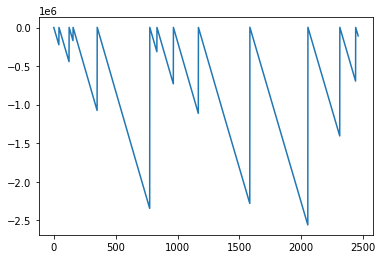

In [16]:
market_data = load_data()
train_data = get_train_data(market_data)
test_data = get_test_data(market_data)
current_max_balance = 0
for epoch in tqdm(range(EPOCH_COUNT)):
    done = False
    cur_epsilon = INIT_EPSILON
    environment = Environment(train_data)
    macro_agent.sell_assets(0)
    while not done:
    
        now_state = environment.get_state(macro_agent)
        macro_agent.q_network.eval()
        decision = np.random.rand()
        if decision < cur_epsilon:
            # epsilon
            id = np.random.choice(3)
            arr = torch.tensor([0,0,0], dtype=torch.float32)
            arr[id] = 1
            action = arr
        else:
            # 1-epsilon
            action = soft_argmax(macro_agent.q_network(now_state).unsqueeze(0))
        

        # reward algo
        cur_reward = calc_reward_one_action(macro_agent, now_state, action)

        environment.taken_action()
        next_state = environment.get_state(macro_agent)
        done = environment.done
        

        replay_memory.push(now_state, action, cur_reward, next_state, done)
        
        # taking batch
        batch = replay_memory.sample(MINI_BATCH_SIZE)
        q = torch.empty(len(batch), dtype=torch.float32)
        current_states_batch = []

        for i, object in enumerate(batch):
            current_states_batch.append(torch.tensor(object.state, dtype=torch.float32))
            if not object.done:
                # r_i + gamma * Q()
                q[i] = object.reward + GAMMA_DISCOUNT * Q_choose_action_and_get_reward(object.next_state)
            else:
                # r_i
                q[i] = object.reward
        # grad d
        macro_agent.q_network.train()
        current_states_batch = torch.stack(current_states_batch)
        #print(macro_agent.q_network(current_states_batch))
        chosen_actions = soft_argmax(macro_agent.q_network(current_states_batch))
        #print(current_states_batch)
        rewards = torch.empty(len(current_states_batch))
        for i in range(len(rewards)):
            rewards[i] = Q_with_action(current_states_batch[i], chosen_actions[i])
        #print(q, rewards)
        q.requires_grad = True
        rewards.requires_grad = True
        loss = criterion(q, rewards)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        cur_epsilon = decay_epsilon(cur_epsilon)  
    

    
    if epoch % 5 == 0:
        # test model
        macro_agent.q_network.eval()
        test_env = Environment(test_data)
        macro_agent.sell_assets(price=0)
        current_balance = [0]
        while not test_env.done:
            now_state = test_env.get_state(macro_agent)
            action = soft_argmax(macro_agent.q_network(now_state).unsqueeze(0))
            price = test_env.get_price()
            if torch.allclose(action, ACTIONS['BUY']):
                prev_assets = macro_agent.estimate_assets(price)
                macro_agent.buy_asset(price)
                now_assets = macro_agent.estimate_assets(price) 
                current_balance.append(current_balance[-1])
            elif torch.allclose(action,ACTIONS['SELL']):
                earning = macro_agent.sell_assets(price)
                current_balance.append(earning)
            else:
                current_balance.append(macro_agent.estimate_assets(price))
            test_env.taken_action()
        plt.plot(current_balance)
        pd.DataFrame(current_balance).to_csv('macro_agent_epoch_{}.csv'.format(epoch))
        plt.savefig('testing_epoch_{}.jpg'.format(epoch))

        if current_balance[-1] > current_max_balance:
            torch.save(macro_agent.q_network.state_dict(), 'best_q_net_epoch_{}'.format(epoch))

    torch.save(macro_agent.q_network.state_dict(), 'q_net_epoch_{}'.format(epoch))  

In [22]:
np.where(current_balance)

TypeError: '>' not supported between instances of 'list' and 'int'

In [ ]:
def soft_argdmax(voxels):
	"""
	Arguments: voxel patch in shape (batch_size, channel, H, W, depth)
	Return: 3D coordinates in shape (batch_size, channel, 3)
	"""
	assert voxels.dim()==5
	# alpha is here to make the largest element really big, so it
	# would become very close to 1 after softmax
	alpha = 1000.0 
	N,C,H,W,D = voxels.shape
	soft_max = nn.functional.softmax(voxels.view(N,C,-1)*alpha,dim=2)
	soft_max = soft_max.view(voxels.shape)
	indices_kernel = torch.arange(start=0,end=H*W*D).unsqueeze(0)
	indices_kernel = indices_kernel.view((H,W,D))
	conv = soft_max*indices_kernel
	indices = conv.sum(2).sum(2).sum(2)
	z = indices%D
	y = (indices/D).floor()%W
	x = (((indices/D).floor())/W).floor()%H
	coords = torch.stack([x,y,z],dim=2)
	return coords